In [11]:
from __future__ import print_function

from IPython import display

import math
import matplotlib
import sklearn
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from numpy import radians, cos, sin, arcsin, arccos, sqrt, pi, arctan2, degrees, arctan

from tqdm import tqdm, tqdm_notebook
tqdm.pandas()
tqdm.pandas(tqdm_notebook)

from joblib import dump, load

from natsort import natsorted
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn import metrics

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans


pd.options.display.max_rows = 10

In [12]:

def haversine(lat1, lon1, lat2, lon2):
    #ensure using numpy and not math, or pandas series cannot be passed
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * arcsin(sqrt(a))
    r = 6378.137 ##radius of earth km
    return c * r

def compute_dist(df):
    next_df = df.shift(1)
    dist = haversine(df.iloc[:,0], df.iloc[:,1],
                    next_df.iloc[:,0], next_df.iloc[:,1])
    return dist

def compute_time(df):
    next_df = df.shift(1)
#     df["time"] = pd.to_datetime(df["time_utc"], format="%Y-%m-%d %H:%M:%S.%f", errors='raise')
    timedelt = df["time"] - next_df["time"]
    return timedelt

def compute_speed(df):
    kinematics = df.copy()
    kinematics["distance_travelled"] = compute_dist(kinematics[["latitude", "longitude"]].astype(float)).values
    kinematics["time_elapsed"] = compute_time(kinematics).values
    kinematics["time_elapsed_seconds"] = kinematics["time_elapsed"]/np.timedelta64(1,'s')
    kinematics["speed m/s"] = (kinematics["distance_travelled"]*1000)/kinematics["time_elapsed_seconds"]
    kinematics["speed kmh"] = kinematics["speed m/s"]*3.6
    kinematics["bearing"] = compute_bearing(kinematics[["latitude", "longitude"]].astype(float))
    kinematics['bearing_diff'] = compute_bearing_diff(kinematics)
    kinematics["rate_of_turn"] = kinematics["bearing_diff"]/kinematics["time_elapsed_seconds"]
    kinematics["acceleration"] = (speed_diff(kinematics["speed m/s"])) /kinematics["time_elapsed_seconds"]
    kinematics.drop(columns = ['time_elapsed'], inplace = True)
    kinematics.fillna(0, inplace = True)
#     df["distance_travelled"] = kinematics["distance_travelled"].values
#     df["speed kmh"] = kinematics["speed kmh"].values
    return kinematics

def compute_bearing(df):
    next_df = df.shift(1)
    bear = cal_bearing(df.iloc[:,0], df.iloc[:,1],
                    next_df.iloc[:,0], next_df.iloc[:,1])
    return bear

def bearing_diff(bearing, prev_bearing):
    
    """
    Calculates the absolute difference between two angles
    Parameters
      bearing: bearing in degrees of the first angle
      prev_bearing: bearing in degrees of the second angle
    Returns the difference in degrees as a float
    """

    # if bearing - prev_bearing <=180 then taking the absolute difference is correct
    if bearing - prev_bearing <= 180:
        bearing_diff = abs(bearing - prev_bearing)
    # otherwise if bearing is larger than previous_bearing the total difference is the prev_bearing plus the difference
    # between 360 and the bearing
    elif bearing > prev_bearing:
        bearing_diff = prev_bearing + (360 - bearing)
    # otherwise if prev_bearing is larger than bearing the total difference is the bearing plus the difference 
    # between 360 and the prev_bearing
    elif prev_bearing > bearing:
        bearing_diff = bearing + (360 - prev_bearing)
    # in all other cases take the absolute difference
    else:
        bearing_diff = abs(bearing - prev_bearing)

    return bearing_diff

def cal_bearing(lat1, lon1, lat2, lon2):
    """
    Calculates the bearing between two points using the formula
        θ = atan2(sin(Δlong).cos(lat2),
                  cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(Δlong))
    """
    
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    dlon = lon2 - lon1

    x = sin(dlon) * cos(lat2)
    y1 = cos(lat1) * sin(lat2)
    y2 = sin(lat1) * cos(lat2) * cos(dlon)
    y = y1 - y2

    initial_bearing = arctan2(x, y)

    initial_bearing = degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

def compute_bearing_diff(df):
    df1 = df.copy()
    df1["prev_bearing"] = df1["bearing"].shift(1)
    df1["bearing diff"] = df1.apply(lambda row: bearing_diff(row['bearing'],row['prev_bearing']),axis=1)
    return df1["bearing diff"]

def speed_diff(df):
    next_df = df.shift(1)
    diff = df - next_df
    return diff

def compute_speed(df):
    kinematics = df.copy()
    kinematics["distance_travelled"] = compute_dist(kinematics[["latitude", "longitude"]].astype(float)).values
    kinematics["time_elapsed"] = compute_time(kinematics).values
    kinematics["time_elapsed_seconds"] = kinematics["time_elapsed"]/np.timedelta64(1,'s')
    kinematics["speed m/s"] = (kinematics["distance_travelled"]*1000)/kinematics["time_elapsed_seconds"]
    kinematics["speed kmh"] = kinematics["speed m/s"]*3.6
    kinematics["bearing"] = compute_bearing(kinematics[["latitude", "longitude"]].astype(float))
    kinematics['bearing_diff'] = compute_bearing_diff(kinematics)
    kinematics["rate_of_turn"] = kinematics["bearing_diff"]/kinematics["time_elapsed_seconds"]
    kinematics["acceleration"] = (speed_diff(kinematics["speed m/s"])) /kinematics["time_elapsed_seconds"]
    kinematics.drop(columns = ['time_elapsed'], inplace = True)
    kinematics.fillna(0, inplace = True)
#     df["distance_travelled"] = kinematics["distance_travelled"].values
#     df["speed kmh"] = kinematics["speed kmh"].values
    return kinematics

In [13]:
df =  pd.read_csv('/mnt/hgfs/FYP/porto_cleaned_100000.csv', parse_dates = ['time'])

In [14]:
grouper = df.groupby('ID')

In [15]:
a = []
b = []
c = []
for name, val in tqdm(grouper):
    idx_grper = val.groupby(val['Unnamed: 0'].diff().ne(1).cumsum())
    for name2, taxi in idx_grper:
        a.append(len(taxi))
        b.append(name)
        c.append(taxi)

100%|██████████| 427/427 [00:29<00:00, 14.28it/s]


In [6]:
val = df[df['ID'] == 20000496]

In [7]:
a = []
b = []
idx_grper = val.groupby(val['Unnamed: 0'].diff().ne(1).cumsum())
for name, taxi in idx_grper:
    a.append(taxi)
    b.append(len(taxi))

In [ ]:
c[13].plot('longitude', 'latitude', kind = 'scatter', figsize = (16,9))

In [260]:
df2 = c[13]

In [261]:
df2

,Unnamed: 0,time,longitude,latitude,ID
528363,0,2013-07-03 16:37:33,-8.617725,41.146101,20000001
528364,1,2013-07-03 16:37:48,-8.617698,41.146101,20000001
528365,2,2013-07-03 16:38:03,-8.617599,41.145786,20000001
528366,3,2013-07-03 16:38:18,-8.617383,41.144913,20000001
528367,4,2013-07-03 16:38:33,-8.616141,41.145228,20000001
...,...,...,...,...,...
528399,36,2013-07-03 16:47:33,-8.605179,41.149764,20000001
528400,37,2013-07-03 16:47:48,-8.605404,41.149764,20000001
528401,38,2013-07-03 16:48:03,-8.606727,41.150043,20000001
528402,39,2013-07-03 16:48:18,-8.606934,41.150079,20000001


In [100]:
df2 = compute_speed(c[1854])

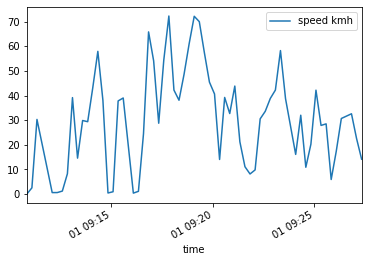

In [101]:
df2.plot('time', 'speed kmh')

In [16]:
def time_to_dest(df):
    end_time = df['time'].iloc[-1]
    df['time_to_dest'] = (end_time - df['time']).dt.total_seconds().astype(int)
def set_dropoff(df):
    df['dropoff_latitude'] = df['latitude'].iloc[-1]
    df['dropoff_longitude'] = df['longitude'].iloc[-1]


In [105]:
df2['time'].iloc[-1] - df2['time']

57230   00:16:30
57231   00:16:15
57232   00:16:00
57233   00:15:30
57234   00:15:15
          ...   
57288   00:01:15
57289   00:01:00
57290   00:00:30
57291   00:00:15
57292   00:00:00
Name: time, Length: 63, dtype: timedelta64[ns]

In [265]:
time_to_dest(df2)
set_dropoff(df2)

df2['dist_to_dest'] = haversine(df2['latitude'].values, df2['longitude'].values, df2['dropoff_latitude'].values, df2['dropoff_longitude'].values)

In [266]:
df2['pickup_weekday'] = df2['time'].dt.weekday
df2['pickup_hour_weekofyear'] = df2['time'].dt.weekofyear
df2['pickup_hour'] = df2['time'].dt.hour
df2['pickup_minute'] = df2['time'].dt.minute
df2['pickup_dt'] = (df2['time'] - df2['time'].min()).dt.total_seconds()
df2['pickup_week_hour'] = df2['pickup_weekday'] * 24 + df2['pickup_hour']

In [267]:
df2.columns

Index(['Unnamed: 0', 'time', 'longitude', 'latitude', 'ID',
       'distance_travelled', 'time_elapsed_seconds', 'speed m/s', 'speed kmh',
       'bearing', 'bearing_diff', 'rate_of_turn', 'acceleration',
       'time_to_dest', 'dropoff_latitude', 'dropoff_longitude', 'dist_to_dest',
       'pickup_weekday', 'pickup_hour_weekofyear', 'pickup_hour',
       'pickup_minute', 'pickup_dt', 'pickup_week_hour'],
      dtype='object')

In [17]:
import tensorflow as tf
from tensorflow.python.keras.backend import tanh, conv1d, expand_dims, squeeze, clip
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding, Flatten, Conv1D, Conv2D, Lambda, concatenate, Reshape, TimeDistributed, MaxPooling1D, Permute, BatchNormalization, ELU
from tensorflow.python.keras.layers.recurrent import LSTM,RNN
from tensorflow.python.keras.layers.core import Dense, Activation, Dropout
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.python.keras import losses
# from tensorflow.python.keras.activations import elu


import tensorflow.python.keras.backend as K


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [18]:
from tensorflow.python.keras import backend as K
# import tensorflow as tf
def rmsle_K(y, y0):
    return K.sqrt(K.mean(K.square(tf.log1p(y) - tf.log1p(y0))))
def rmsletf(y_pred, y_true): 
    y_pred= tf.cast(y_pred, tf.float64) 
    y_true= tf.cast(y_true, tf.float64) 
    y_pred=tf.nn.relu(y_pred) 
    return np.abs(tf.sqrt(tf.reduce_mean(tf.squared_difference(tf.log1p(y_pred), tf.log1p(y_true)))))

In [268]:
x = df2[['longitude', 'latitude']].values
x = x.reshape(len(x), 2,1)
y = df2[['time_to_dest']].values
y = y.reshape(len(y),1,1)

In [269]:
y.shape

(63, 1, 1)

In [270]:
x.shape

(63, 2, 1)

In [156]:
# define two sets of inputs
inputA = Input(shape=(2,1))
# the first branch operates on the first input
cnn = Dense(16, activation="tanh")(inputA)
# x = tanh(x)
# cnn = Reshape((16,2))(cnn)
cnn = Permute(dims = (2,1))(cnn)
cnn = Conv1D(32, activation = 'elu', kernel_size = 3)(cnn)
cnn = MaxPooling1D(3)(cnn)
cnn_out = Flatten()(cnn)
# cnn = Reshape((None,16))(cnn)
# cnn = Dense(16, activation = 'relu')(cnn)
# cnn_output = Dense(16, activation='sigmoid')(cnn)
# cnn = Model(inputs=inputA, outputs=cnn_out)

In [26]:

mfcc_input = Input(shape=(None, 18, 1), dtype='float', name='mfcc_input')
CNN_out = TimeDistributed(Conv1D(32, 3, activation='relu'))(mfcc_input)
CNN_out = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True)(CNN_out)
CNN_out = TimeDistributed(MaxPooling1D(pool_size=(3), strides=None, padding='valid'))(CNN_out)
CNN_out = Permute(dims = (3,2,1))(CNN_out)

cnn = Model(inputs=mfcc_input, outputs=CNN_out)

In [27]:
cnn.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mfcc_input (InputLayer)      [(None, None, 18, 1)]     0         
_________________________________________________________________
time_distributed (TimeDistri (None, None, 16, 32)      128       
_________________________________________________________________
batch_normalization (BatchNo (None, None, 16, 32)      128       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 5, 32)       0         
_________________________________________________________________
permute_2 (Permute)          (None, 32, 5, None)       0         
Total params: 256
Trainable params: 192
Non-trainable params: 64
_________________________________________________________________


In [28]:
cnn = Sequential()
cnn.add(Dense(16, activation='tanh'))
cnn.add(Conv1D(1, kernel_size = 4, activation = "elu"))

In [29]:
auxiliary_output = Dense(1, activation='sigmoid', name='aux_output')(cnn_out)

In [ ]:
auxiliary_input = Input(shape=(18,1), name='aux_input')
x = concatenate([cnn_out, auxiliary_input], axis = 1)

In [531]:
# x = Dense(64, activation='relu')(x)

In [532]:
x = LSTM(100, return_sequences = True)(x)
x = Dropout(0.2)(x)
x = LSTM(100,return_sequences = True)(x)
x = Dropout(0.2)(x)
x = LSTM(50)(x)
x = Dropout(0.2)(x)
main_output = Dense(1, activation='sigmoid', name='main_output')(x)
model = Model(inputs=[inputA, auxiliary_input], outputs=[main_output])


In [533]:
model.compile(optimizer='adam', loss='mae', metrics=[rmsletf])

In [ ]:
model.summary()

In [228]:
model = Sequential()

# first layer
model.add(LSTM(units=512, batch_input_shape=(None,18,1),return_sequences=False, activation = 'tanh'))
model.add(Dropout(0.2))

# second layer
# model.add(Dense(128, 1))
# model.add(LSTM(units=100,return_sequences=False))
# model.add(Dropout(0.2))

# third layer
# model.add(LSTM(units=50,return_sequences=False))
# model.add(Dropout(0.2))

# fourth dense layer
model.add(Dense(units=1))


model.compile(loss='mean_absolute_error',optimizer='adam',metrics=[rmsle_K])
model.summary()
          

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 512)               1052672   
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 513       
Total params: 1,053,185
Trainable params: 1,053,185
Non-trainable params: 0
_________________________________________________________________


In [271]:
train_x = df2.drop(['Unnamed: 0', 'time', 'ID', 'time_elapsed_seconds', 'time_to_dest'] ,axis =1)
train_y = df2[['time_to_dest']]

In [99]:
df2[df2[['time_to_dest']] < 75]

,Unnamed: 0,time,longitude,latitude,ID,distance_travelled,time_elapsed_seconds,speed m/s,speed kmh,bearing,...,dropoff_longitude,dist_to_dest,pickup_weekday,pickup_hour_weekofyear,pickup_hour,pickup_minute,pickup_dt,pickup_week_hour,next_lat,next_lon
2382005,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2382006,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2382007,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2382008,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2382009,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2382046,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2382047,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2382048,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2382049,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [158]:
mu, sigma = 0, 5
noise = np.random.normal(mu, sigma, [67,1]) 
train_y = train_y + noise

In [272]:
x_data = train_x.values
x_data = np.array(x_data)
# x_data = x_data.reshape(19828,5,1)
x_data.shape

(63, 18)

In [273]:
y_data = train_y.values
y_data.shape

(63, 1)

In [274]:
# x_test = x_data
# y_test = y_data

In [164]:
x_train = x_data[0:50]
y_train = y_data[0:50]
x_test = x_data[50:]
y_test = y_data[50:]

In [275]:
# sc = MinMaxScaler(feature_range=(-1,1))
scy = MinMaxScaler(feature_range=(-1,1))
sc = sklearn.preprocessing.StandardScaler()
# new_df= x_data[].reshape(x_data.shape[0],5)

x_train = sc.fit_transform(x_train)
x_train = x_train.reshape(50,18,1)
x_test = sc.transform(x_test).reshape(17,18,1)


y_train = scy.fit_transform(y_train)
y_test = scy.transform(y_test)

# new_y_data = y_data
# new_y_data = scy.fit_transform(y_)

In [229]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=10, verbose=1)

In [ ]:
model.fit(x_train,y_train,epochs=50,validation_data=(x_test,y_test), callbacks = [callback_early_stopping], verbose = 1)

In [ ]:

c2 = list(zip(x_test, y_test))

random.shuffle(c)

x_test, y_test = zip(*c2)


In [ ]:
result = model.predict(np.array(x_test))
result

In [277]:
res_df = scy.inverse_transform(result)

In [278]:
y_test_actual=scy.inverse_transform(y_test)

In [279]:
mean_absolute_error(res_df , y_test_actual )

15577.308237227182

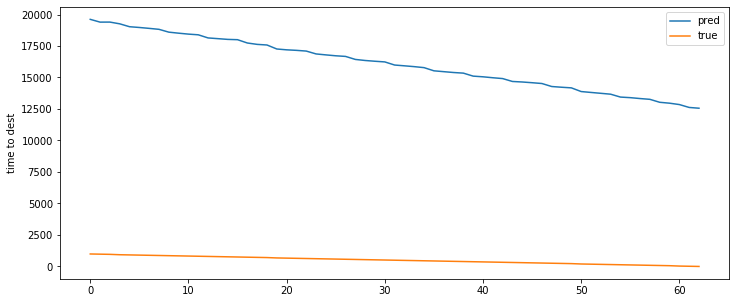

In [280]:
plt.figure(figsize=(12,5))
plt.plot(res_df, label = 'pred')
plt.plot(y_test_actual, label = 'true')
plt.ylabel('time to dest')
plt.legend()

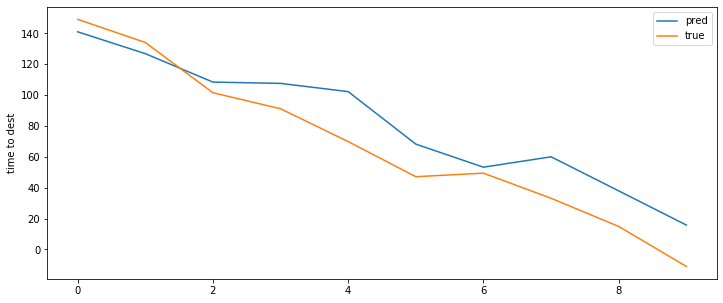

In [432]:
plt.figure(figsize=(12,5))
plt.plot(res_df, label = 'pred')
plt.plot(y_test_actual, label = 'true')
plt.ylabel('time to dest')
plt.legend()

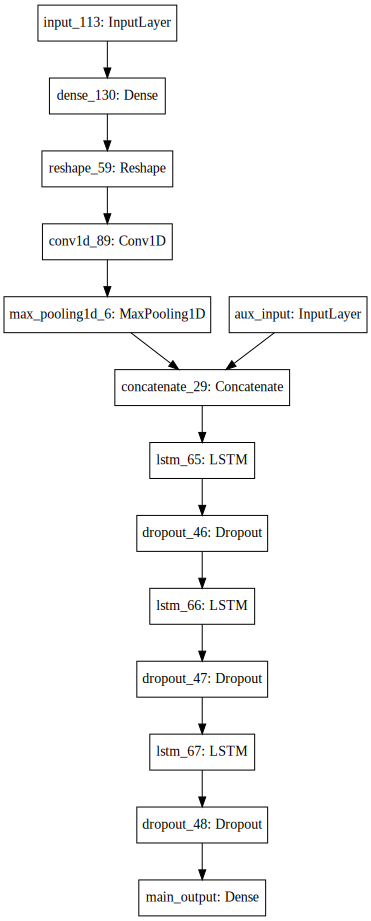

In [486]:
from IPython.display import SVG
from tensorflow.python.keras.utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [487]:
aux_x = df2.drop(['Unnamed: 0', 'time', 'ID', 'time_elapsed_seconds', 'time_to_dest'] ,axis =1)
cnn_x = df2[['latitude', 'longitude']]
# aux_x = train_x.drop(['latitude', 'longitude'], axis = 1)
train_y = df2[['time_to_dest']]

In [488]:
aux_x.shape

(60, 18)

In [489]:
cnn_x = cnn_x.values
aux_x = aux_x.values
y_data = train_y.values
# x_data = x_data.reshape(19828,5,1)
cnn_x.shape

(60, 2)

In [490]:
cnn_x_train = cnn_x[0:50]
aux_x_train = aux_x[0:50]
y_train = y_data[0:50]
cnn_x_test = cnn_x[50:]
aux_x_test = aux_x[50:]
y_test = y_data[50:]

In [491]:
# sc = MinMaxScaler(feature_range=(-1,1))
scy = MinMaxScaler(feature_range=(-1,1))
sca = sklearn.preprocessing.StandardScaler()
scl = sklearn.preprocessing.StandardScaler()
# new_df= x_data[].reshape(x_data.shape[0],5)

cnn_x_train = scl.fit_transform(cnn_x_train)
cnn_x_train = cnn_x_train.reshape(len(cnn_x_train), 2, 1)
aux_x_train = sca.fit_transform(aux_x_train)
aux_x_train = aux_x_train.reshape(len(aux_x_train), 18, 1)

cnn_x_test = scl.transform(cnn_x_test).reshape(len(cnn_x_test), 2, 1)
aux_x_test = sca.transform(aux_x_test).reshape(len(aux_x_test), 18, 1)

y_train = scy.fit_transform(y_train)
y_test = scy.transform(y_test)

# new_y_data = y_data
# new_y_data = scy.fit_transform(y_)

In [ ]:
model.fit([cnn_x_train, aux_x_train], [y_train], validation_data = ([cnn_x_test, aux_x_test], y_test),
          epochs=50)

In [456]:
result = model.predict([cnn_x_test, aux_x_test])
result

array([[0.00039375],
       [0.00039527],
       [0.00039431],
       [0.00039303],
       [0.00039306],
       [0.00039351],
       [0.00039288],
       [0.0003922 ],
       [0.00039209],
       [0.00039205]], dtype=float32)

In [457]:
res_df = scy.inverse_transform(result)

In [458]:
y_test_actual=scy.inverse_transform(y_test)

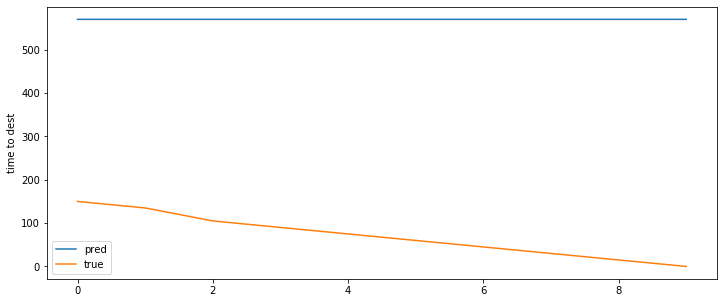

In [459]:
plt.figure(figsize=(12,5))
plt.plot(res_df, label = 'pred')
plt.plot(y_test_actual, label = 'true')
plt.ylabel('time to dest')
plt.legend()

In [ ]:
res_df

In [ ]:
y_test_actual

In [ ]:
metrics.mean_absolute_error(res_df, y_test_actual)

In [19]:
for i, d in enumerate(c):
    if len(d) < 40:
        c.pop(i)

In [ ]:
counter = 0
for i in c:
    i.plot('longitude', 'latitude', kind = 'scatter', figsize = (16,9))
    counter += 1
    if counter > 5:
        break

In [ ]:
def coord_pca(taxi):
    coords = np.vstack((taxi[['pickup_latitude', 'pickup_longitude']].values,
                        taxi[['dropoff_latitude', 'dropoff_longitude']].values))
    pca = PCA()
    pca = pca.fit(coords)
    taxi['pickup_pca0'] = pca.transform(taxi[['pickup_latitude', 'pickup_longitude']])[:, 0]
    taxi['pickup_pca1'] = pca.transform(taxi[['pickup_latitude', 'pickup_longitude']])[:, 1]
    taxi['dropoff_pca0'] = pca.transform(taxi[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
    taxi['dropoff_pca1'] = pca.transform(taxi[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

In [22]:
km = KMeans(
    n_clusters=40, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
coordinates = pd.concat(c)[["longitude", "latitude"]].sample(10000).values
km.fit(coordinates)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
       n_clusters=40, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [23]:
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.latitude).abs()
    
    #the Haversine version
    foob = df[["latitude", "longitude","dropoff_latitude", "dropoff_longitude"]].astype(float)
    df['hav_dist_lat'] = haversine(foob.iloc[:,0], foob.iloc[:,1],foob.iloc[:,2],foob.iloc[:,1])
    df['hav_dist_lon'] = haversine(foob.iloc[:,2], foob.iloc[:,1],foob.iloc[:,2],foob.iloc[:,3])
    
    
def convert_km(df):
    df['abs_diff_longitude'] = df.abs_diff_longitude*80.4
    df['abs_diff_latitude'] = df.abs_diff_latitude*111

In [24]:
d = []
for i, df in (enumerate(c)):
    df2 = compute_speed(c[i])
    time_to_dest(df2)
    set_dropoff(df2)
    add_travel_vector_features(df2)
    convert_km(df2)
    df2['Euclidean'] = (df2.abs_diff_latitude**2 + df2.abs_diff_longitude**2)**0.5 
    
    df2['manh_length_hav'] = df2.hav_dist_lat + df2.hav_dist_lon
    df2['manh_length_euc'] = df2.abs_diff_latitude + df2.abs_diff_longitude
    
    df2['minkowski_0.9'] = (df2.hav_dist_lat**0.92 + df2.hav_dist_lon**0.92)**(1/0.92)
    df2['dist_to_dest'] = haversine(df2['latitude'].values, df2['longitude'].values, df2['dropoff_latitude'].values, df2['dropoff_longitude'].values)
    df2['pickup_weekday'] = df2['time'].dt.weekday
    df2['pickup_hour_weekofyear'] = df2['time'].dt.weekofyear
    df2['pickup_hour'] = df2['time'].dt.hour
    df2['pickup_minute'] = df2['time'].dt.minute
    df2['pickup_dt'] = (df2['time'] - df2['time'].min()).dt.total_seconds()
    df2['pickup_week_hour'] = df2['pickup_weekday'] * 24 + df2['pickup_hour']
    df2[['next_lat', 'next_lon']] = df2[['latitude', 'longitude']].shift(-5)
    
    coordinates = df2[['latitude', 'longitude']]
    pickup_km = km.predict(coordinates)
    df2["pickup_cluster"] = pickup_km
    
    coordinates = df2[['dropoff_latitude', 'dropoff_longitude']]
    dropoff_km = km.predict(coordinates)
    df2["dropoff_cluster"] = dropoff_km
    
    d.append(df2)
    if i > 3000:
        break

In [111]:
for i in d:
    i.dropna(inplace = True)

In [ ]:
d

In [55]:
import random
random.shuffle(d)
mu, sigma = 0, 5

In [56]:
x_data = []
for i in d:
    x_data.append(i.drop(['Unnamed: 0', 'time', 'ID', 'time_elapsed_seconds', 'time_to_dest', 'next_lat', 'next_lon'] ,axis =1))
y_data = []
for i in d:
    noise = np.random.normal(mu, sigma, [len(i),1]) 
    y_data.append(i[['time_to_dest']] + abs(noise))
#     y_data.append(i[['next_lat', 'next_lon']])

In [57]:
y_data[1]

,time_to_dest
1834569,1232.394970
1834570,1206.022104
1834571,1190.818638
1834572,1147.173416
1834573,1112.498453
...,...
1834637,71.476660
1834638,52.516723
1834639,33.813959
1834640,15.578406


In [58]:
x_data[1]

,longitude,latitude,distance_travelled,speed m/s,speed kmh,bearing,bearing_diff,rate_of_turn,acceleration,dropoff_latitude,...,minkowski_0.9,dist_to_dest,pickup_weekday,pickup_hour_weekofyear,pickup_hour,pickup_minute,pickup_dt,pickup_week_hour,pickup_cluster,dropoff_cluster
1834569,-8.609679,41.171139,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.236812,...,13.129700,8.896643,2,28,4,36,0.0,52,0,0
1834570,-8.609697,41.171130,0.001811,0.060358,0.217289,56.406526,0.000000,0.000000,0.000000,41.236812,...,13.129124,8.896607,2,28,4,36,30.0,52,0,0
1834571,-8.609697,41.171130,0.000000,0.000000,0.000000,0.000000,56.406526,3.760435,-0.004024,41.236812,...,13.129124,8.896607,2,28,4,37,45.0,52,0,0
1834572,-8.609697,41.171130,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.236812,...,13.129124,8.896607,2,28,4,37,90.0,52,0,0
1834573,-8.609688,41.171121,0.001254,0.041800,0.150480,323.029516,36.970484,1.232349,0.001393,41.236812,...,13.130987,8.897860,2,28,4,38,120.0,52,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1834637,-8.670213,41.236794,0.002507,0.055713,0.200567,36.942855,94.615237,2.102561,-0.003237,41.236812,...,0.002004,0.002004,2,28,4,55,1170.0,52,0,0
1834638,-8.670231,41.236794,0.001507,0.100454,0.361633,89.999994,53.057140,3.537143,0.002983,41.236812,...,0.003726,0.002507,2,28,4,56,1185.0,52,0,0
1834639,-8.670231,41.236803,0.001002,0.066792,0.240450,180.000000,90.000006,6.000000,-0.002244,41.236812,...,0.002660,0.001809,2,28,4,56,1200.0,52,0,0
1834640,-8.670231,41.236803,0.000000,0.000000,0.000000,0.000000,180.000000,12.000000,-0.004453,41.236812,...,0.002660,0.001809,2,28,4,56,1215.0,52,0,0


In [59]:
x_train = x_data[0:2900]
x_test = x_data[2900:]
y_train = y_data[0:2900]
y_test = y_data[2900:]

In [60]:
# sc = MinMaxScaler(feature_range=(-1,1))
scy = MinMaxScaler(feature_range=(-1,1))
# scy = sklearn.preprocessing.MaxAbsScaler()
sc = sklearn.preprocessing.StandardScaler()
# new_df= x_data[].reshape(x_data.shape[0],5)

sc.fit(pd.concat(x_train).values)
scy.fit(pd.concat(y_train).values)


MinMaxScaler(copy=True, feature_range=(-1, 1))

In [61]:
for i, data in enumerate(x_train):
    x_train[i] = sc.transform(data)
    
for i, data in enumerate(y_train):
    y_train[i] = scy.transform(data)

In [62]:
x_test = sc.transform(pd.concat(x_test).values)
y_test = scy.transform(pd.concat(y_test).values)
# y_test = pd.concat(y_test).values

In [586]:
x_train[1][12:15,0:2]

array([[-0.96166058, -0.07873294],
       [-0.92260041, -0.07734957],
       [-0.87270056, -0.07077855]])

In [310]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """
    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, 28)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, 1)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            j = np.random.randint(len(x_train))
            # Get a random start-index.
            # This points somewhere into the training-data.
            try:
                idx = np.random.randint(len(x_train[j]) - sequence_length)
            except:
                continue
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train[j][idx:idx+sequence_length]
            y_batch[i] = y_train[j][idx:idx+sequence_length]
#             x_batch[i] = x_train[j][0:sequence_length]
#             y_batch[i] = y_train[j][0:sequence_length]
        
        
        yield (x_batch, y_batch)

In [30]:
def batch_generator_multi_td(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """
    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        cnn_x_shape = (batch_size, sequence_length, 2)
        cnn_x_batch = np.zeros(shape=cnn_x_shape, dtype=np.float16)
        cnn_x_batch = cnn_x_batch.reshape(-1,2,sequence_length,1)
        aux_x_shape = (batch_size, sequence_length, 18)
        aux_x_batch = np.zeros(shape=aux_x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, 1)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            j = np.random.randint(len(x_train))
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(len(x_train[j]) - sequence_length)
            
            # Copy the sequences of data starting at this index.
            batchfiles = x_train[j][idx:idx+sequence_length, 0:2]
            cnn_x_batch[i] = batchfiles.reshape((2,sequence_length, -1))
            aux_x_batch[i] = x_train[j][idx:idx+sequence_length]
            y_batch[i] = y_train[j][idx:idx+sequence_length]
#             x_batch[i] = x_train[j][0:sequence_length]
#             y_batch[i] = y_train[j][0:sequence_length]
        
        
        yield [cnn_x_batch, aux_x_batch], y_batch

In [33]:
def batch_generator_multi(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """
    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        cnn_x_shape = (batch_size, sequence_length, 2)
        cnn_x_batch = np.zeros(shape=cnn_x_shape, dtype=np.float16)
        aux_x_shape = (batch_size, sequence_length, 26)
        aux_x_batch = np.zeros(shape=aux_x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, 1)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            j = np.random.randint(len(x_train))
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(len(x_train[j]) - sequence_length)
            
            # Copy the sequences of data starting at this index.

            cnn_x_batch[i] = x_train[j][idx:idx+sequence_length, 0:2]
            aux_x_batch[i] = x_train[j][idx:idx+sequence_length, 2:]
            y_batch[i] = y_train[j][idx:idx+sequence_length]
#             x_batch[i] = x_train[j][0:sequence_length]
#             y_batch[i] = y_train[j][0:sequence_length]
        
        
        yield [cnn_x_batch, aux_x_batch], y_batch

In [69]:
for i, data in enumerate(x_train):
    if len(x_train[i]) < 40:
        x_train.pop(i)
        y_train.pop(i)

In [70]:
x_len = []
for i, data in enumerate(x_train):
    x_len.append(len(x_train[i]))
    

(array([121.,  93.,   0.,  87.,   0.,  85.,  78.,   0.,  74.,   0.,  72.,
         61.,   0.,  74.,   0.,  64.,  66.,   0.,  61.,   0.,  50.,   0.,
         57.,  58.,   0.,  37.,   0.,  48.,  35.,   0.,  49.,   0.,  39.,
         33.,   0.,  34.,   0.,  34.,  33.,   0.,  28.,   0.,  18.,   0.,
         27.,  22.,   0.,  17.,   0.,  18.,  19.,   0.,  19.,   0.,  17.,
         16.,   0.,  15.,   0.,  11.,   0.,  17.,  14.,   0.,  18.,   0.,
         11.,   5.,   0.,   8.,   0.,  12.,   9.,   0.,  11.,   0.,  12.,
          4.,   0.,   9.,   0.,   5.,   0.,   6.,   8.,   0.,   2.,   0.,
          5.,   5.,   0.,   5.,   0.,   3.,   3.,   0.,   5.,   0.,   3.,
          3.]),
 array([40.  , 40.59, 41.18, 41.77, 42.36, 42.95, 43.54, 44.13, 44.72,
        45.31, 45.9 , 46.49, 47.08, 47.67, 48.26, 48.85, 49.44, 50.03,
        50.62, 51.21, 51.8 , 52.39, 52.98, 53.57, 54.16, 54.75, 55.34,
        55.93, 56.52, 57.11, 57.7 , 58.29, 58.88, 59.47, 60.06, 60.65,
        61.24, 61.83, 62.42, 63.01

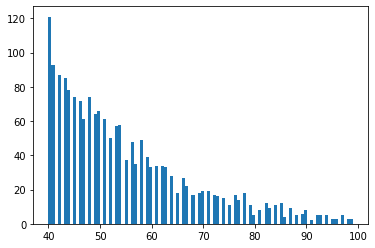

In [71]:
plt.hist(np.array(x_len)[np.array(x_len) < 100], bins = 100)

In [ ]:
y_data[2900:]

In [43]:
batch_size = 256
sequence_length = 35

In [311]:
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)
cnnx_batch, y_batch = next(generator)

In [272]:
cnnx_batch[0].shape

(30, 18)

In [ ]:
print(x_batch.shape)
print(y_batch.shape)

In [ ]:
y_batch

In [312]:
validation_data = (np.expand_dims(x_test, axis =0),
                   np.expand_dims(y_test, axis=0))

In [77]:
validation_data = ([np.expand_dims(x_test[:,0:2], axis=0).reshape(1,2,-1,1), np.expand_dims(x_test, axis =0)],
                   np.expand_dims(y_test, axis=0))

In [73]:
validation_data = ([np.expand_dims(x_test[:,0:2], axis=0), np.expand_dims(x_test[:,2:], axis =0)],
                   np.expand_dims(y_test, axis=0))

In [49]:
validation_data[0][0].shape

(4762, 28)

In [50]:
validation_data[1]

array([[[-0.90109517],
        [-0.90273209],
        [-0.90540749],
        ...,
        [-0.99674747],
        [-0.99844067],
        [-0.9998758 ]]])

In [207]:
num_steps = 50
lats = 128
lons = 128
features = 4
out_feats = 3

model = Sequential()
model.add(TimeDistributed(Conv1D(16, (3), activation='relu', padding='same'), 
                          input_shape=(num_steps, lats, features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=(2))))
model.add(TimeDistributed(Conv1D(32, (3), activation='relu', padding='same')))
model.add(TimeDistributed(MaxPooling1D(pool_size=(2))))
model.add(TimeDistributed(Conv1D(32, (3), activation='relu', padding='same')))
model.add(TimeDistributed(MaxPooling1D(pool_size=(2))))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(units=64, return_sequences=True))


In [205]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_82 (TimeDis (None, 50, 128, 16)       208       
_________________________________________________________________
time_distributed_83 (TimeDis (None, 50, 64, 16)        0         
_________________________________________________________________
time_distributed_84 (TimeDis (None, 50, 64, 32)        1568      
_________________________________________________________________
time_distributed_85 (TimeDis (None, 50, 32, 32)        0         
_________________________________________________________________
time_distributed_86 (TimeDis (None, 50, 32, 32)        3104      
_________________________________________________________________
time_distributed_87 (TimeDis (None, 50, 16, 32)        0         
_________________________________________________________________
time_distributed_88 (TimeDis (None, 50, 512)          

In [83]:
cnn_input = Input(shape=(2, 30,1), dtype='float', name='cnn_input')
CNN_out = (TimeDistributed(Conv1D(16, (3), activation='relu', padding='same')))(cnn_input)

CNN_out = (TimeDistributed(MaxPooling1D(pool_size=(2), strides=None, padding='valid')))(CNN_out)
# CNN_out = Permute(dims = (2,3,1))(CNN_out)
CNN_out = (TimeDistributed(Flatten()))(CNN_out)
# CNN_out = Permute(dims = (2,1))(CNN_out)
cnn = Model(inputs=cnn_input, outputs=CNN_out)

In [292]:
cnn_input = Input(shape=(None,2), dtype='float', name='cnn_input')
CNN_out = Lambda(lambda x: expand_dims(x, -1))(cnn_input)
CNN_out = (TimeDistributed(Dense(8, activation = 'tanh')))(CNN_out)
# CNN_out = (TimeDistributed(Conv1D(16, (16), activation='tanh', padding='same')))(CNN_out)
# CNN_out = (TimeDistributed(MaxPooling1D(pool_size=(2), strides=None, padding='valid')))(CNN_out)
CNN_out = (TimeDistributed(Conv1D(4, (10), activation='elu', padding='same')))(CNN_out)
CNN_out = (TimeDistributed(MaxPooling1D(pool_size=(2), strides=None, padding='valid')))(CNN_out)
# CNN_out = Permute(dims = (2,3,1))(CNN_out)
CNN_out = (TimeDistributed(Flatten()))(CNN_out)
# CNN_out = (TimeDistributed(Dense(4)))(CNN_out)
# CNN_out = Permute(dims = (2,1))(CNN_out)
# CNN_out = (Lambda(lambda x: squeeze(x, -1)))(CNN_out)
cnn = Model(inputs=cnn_input, outputs=CNN_out)

In [674]:
cnn_input = Input(shape=(30,2), dtype='float', name='cnn_input')
CNN_out = Dense(16)(cnn_input)
CNN_out = (Conv1D(2, (6), activation='relu', padding='same'))(cnn_input)
# CNN_out = (Conv1D(16, (15), activation='relu', padding='same'))(CNN_out)
CNN_out = (MaxPooling1D(pool_size=(3), strides=None, padding='valid'))(CNN_out)
# CNN_out = (Flatten())(CNN_out)
cnn = Model(inputs=cnn_input, outputs=CNN_out)

In [109]:
cnn.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cnn_input (InputLayer)       [(None, None, 2)]         0         
_________________________________________________________________
lambda_6 (Lambda)            (None, None, 2, 1)        0         
_________________________________________________________________
time_distributed_24 (TimeDis (None, None, 2, 8)        16        
_________________________________________________________________
time_distributed_25 (TimeDis (None, None, 2, 4)        324       
_________________________________________________________________
time_distributed_26 (TimeDis (None, None, 1, 4)        0         
_________________________________________________________________
time_distributed_27 (TimeDis (None, None, 4)           0         
Total params: 340
Trainable params: 340
Non-trainable params: 0
____________________________________________________________

In [491]:
def layer_clip(input, maxx, minn):
    return K.clip(input, minn, maxx)

In [318]:
aux_input = Input(shape=(None,28), name='aux_input')
x = GRU(50, return_sequences = True, activation = 'tanh')(aux_input)
# x = Dropout(0.5)(x)
x = GRU(38,return_sequences = True, activation = 'tanh')(x)
# x = Dropout(0.01)(x)
x = GRU(24,return_sequences = True, activation = 'tanh')(x)
# x = Dropout(0.2)(x)
# x = concatenate([CNN_out, x], axis = 2)
# x = Dense(30, activation = 'elu')(x)
main_output = Dense(1, name='main_output')(x)
# x = Dense(1, name='main_output')(x)
# main_output = ELU(alpha = 1.5)(x)
# main_output = Lambda(lambda x: K.clip(x, -1.0,1.0))(x)
# model = Model(inputs= [cnn_input,aux_input], outputs=[main_output])
model = Model(inputs= aux_input, outputs=[main_output])

In [232]:
aux_input = Input(shape=(None,26), name='aux_input')
x = GRU(40, return_sequences = True, activation = 'tanh')(aux_input)
# x = Dropout(0.5)(x)
x = GRU(20,return_sequences = True, activation = 'tanh')(x)
# x = Dropout(0.01)(x)
# x = GRU(24,return_sequences = True, activation = 'tanh')(x)
# x = Dropout(0.2)(x)
x = concatenate([CNN_out, x], axis = 2)
# x = Dense(30, activation = 'elu')(x)
main_output = Dense(1, name='main_output')(x)
# x = Dense(1, name='main_output')(x)
# main_output = ELU(alpha = 1.5)(x)
# main_output = Lambda(lambda x: K.clip(x, -1.0,1.0))(x)
model = Model(inputs= [cnn_input,aux_input], outputs=[main_output])
# model = Model(inputs= aux_input, outputs=[main_output])

In [ ]:
auxiliary_output = Dense(1, activation='sigmoid', name='aux_output')(CNN_out)

In [293]:
auxiliary_input = Input(shape=(None,26), name='aux_input')
x = concatenate([CNN_out, auxiliary_input], axis = 2)

In [294]:
x = GRU(50, return_sequences = True, activation = 'tanh')(x)
# x = Dropout(0.2)(x)
x = GRU(38,return_sequences = True, activation = 'tanh')(x)
x = GRU(24,return_sequences = True, activation = 'tanh')(x)
# x = Dropout(0.2)(x)
# x = Dropout(0.2)(x)
main_output = Dense(1, name='main_output')(x)
model = Model(inputs=[cnn_input, auxiliary_input], outputs=[main_output])


In [319]:
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])

In [320]:
model.summary()

Model: "model_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
aux_input (InputLayer)       [(None, None, 28)]        0         
_________________________________________________________________
gru_61 (GRU)                 (None, None, 50)          11850     
_________________________________________________________________
gru_62 (GRU)                 (None, None, 38)          10146     
_________________________________________________________________
gru_63 (GRU)                 (None, None, 24)          4536      
_________________________________________________________________
main_output (Dense)          (None, None, 1)           25        
Total params: 26,557
Trainable params: 26,557
Non-trainable params: 0
_________________________________________________________________


In [113]:
from IPython.display import SVG
from tensorflow.python.keras.utils import model_to_dot

In [114]:
model_to_dot(model)

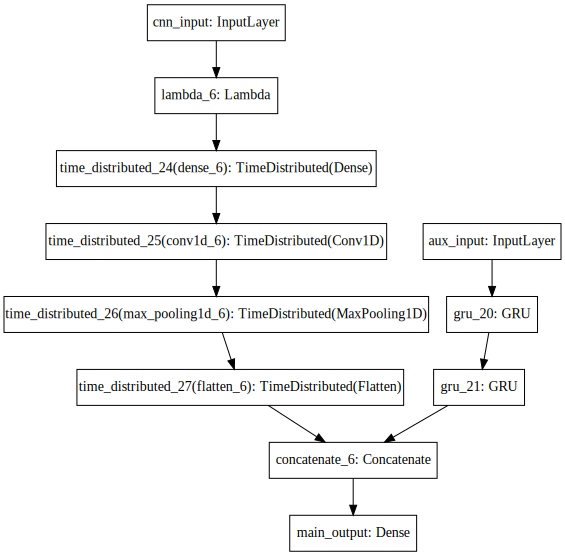

In [115]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [52]:
%load_ext tensorboard
!rm -rf ./logs/ 

In [36]:
# import datetime
# log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [321]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

0.05
0.1
0.2
0.3
0.4
Epoch 00031: early stopping


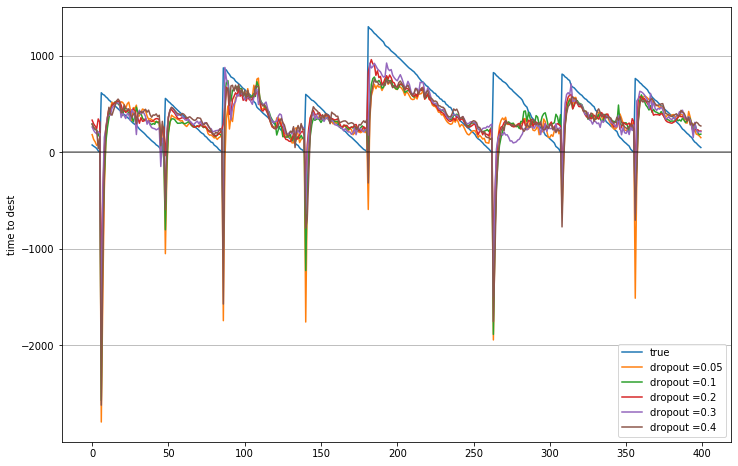

In [409]:
# batch_size = [40,80,120]
num_units = [18,19,20,21,22]
drop_rate = [0.05,0.1,0.2,0.3, 0.4]
plt.figure(figsize=(12, 8))
plt.plot(y_test_rescaled[1100:1500], label = 'true')
for i, j in enumerate(drop_rate):
    print(j)
    generator = batch_generator_multi(batch_size=batch_size, sequence_length=sequence_length)
    
    path_checkpoint = '23_checkpoint.keras'
    callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                          monitor='val_loss',
                                          verbose=0,
                                          save_weights_only=True,
                                          save_best_only=True)
    callback_early_stopping = EarlyStopping(monitor='val_loss',
                                            patience=5, verbose=1)
    callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                       histogram_freq=0,
                                       write_graph=False)
    callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                           factor=0.1,
                                           min_lr=1e-4,
                                           patience=0,
                                           verbose=0)

    callbacks = [callback_early_stopping,
                 callback_checkpoint,
                 callback_tensorboard,
                 callback_reduce_lr]
    
    cnn_input = Input(shape=(None,2), dtype='float', name='cnn_input')
    CNN_out = Lambda(lambda x: expand_dims(x, -1))(cnn_input)
    CNN_out = (TimeDistributed(Dense(8, activation = 'tanh')))(CNN_out)
    # CNN_out = (TimeDistributed(Conv1D(16, (16), activation='tanh', padding='same')))(CNN_out)
    # CNN_out = (TimeDistributed(MaxPooling1D(pool_size=(2), strides=None, padding='valid')))(CNN_out)
    CNN_out = (TimeDistributed(Conv1D(16, (20), activation='elu', padding='same')))(CNN_out)
    CNN_out = (TimeDistributed(MaxPooling1D(pool_size=(1), strides=None, padding='valid')))(CNN_out)
    # CNN_out = Permute(dims = (2,3,1))(CNN_out)
    CNN_out = (TimeDistributed(Flatten()))(CNN_out)
    
    auxiliary_input = Input(shape=(None,26), name='aux_input')
    x = concatenate([CNN_out, auxiliary_input], axis = 2)

    aux_input = Input(shape=(None,26), name='aux_input')
    x = GRU(60, return_sequences = True, activation = 'tanh')(aux_input)
    x = Dropout(j)(x)
#     x = GRU(20,return_sequences = True, activation = 'tanh')(x)
    main_output = Dense(1, name='main_output')(x)

    model = Model(inputs= [cnn_input, aux_input], outputs=[main_output])
    model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
    model.fit_generator(generator=generator,
                        epochs=50,
                        steps_per_epoch=50,
                        validation_data=validation_data,
                        callbacks=callbacks,
                       verbose = 0)
    try:
        model.load_weights(path_checkpoint)
    except Exception as error:
        print("Error trying to load checkpoint.")
        print(error)
#     y_pred = model.predict(np.expand_dims(x_test, axis =0))
    y_pred = model.predict([np.expand_dims(x_test[:,0:2], axis=0), np.expand_dims(x_test[:,2:], axis =0)])

    y_pred_rescaled = scy.inverse_transform(y_pred[0])
    y_test_rescaled = scy.inverse_transform(y_test)

#     plt.figure(figsize=(12, 8))
    plt.ylabel('time to dest')
    # plt.plot(y_pred_rescaled, label = 'pred')
    # plt.plot(y_test_rescaled, label = 'true')
    plt.plot(y_pred_rescaled[1100:1500], label = 'dropout =' + str(j))

#     plt.plot(y_test_rescaled[1400:2000], label = 'true')
#     plt.legend()
plt.grid(axis = 'y')
plt.axhline(0, color='black',alpha = 0.5)
plt.legend() 
plt.show()

Epoch 1/50
199/200 [============================>.] - ETA: 0s - loss: 0.1248 - mean_absolute_error: 0.1248
Epoch 00001: val_loss improved from inf to 0.03188, saving model to 23_checkpoint.keras
200/200 [==============================] - 39s 195ms/step - loss: 0.1244 - mean_absolute_error: 0.1244 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 2/50
199/200 [============================>.] - ETA: 0s - loss: 0.0232 - mean_absolute_error: 0.0232
Epoch 00002: val_loss improved from 0.03188 to 0.02737, saving model to 23_checkpoint.keras
200/200 [==============================] - 25s 125ms/step - loss: 0.0232 - mean_absolute_error: 0.0232 - val_loss: 0.0274 - val_mean_absolute_error: 0.0274
Epoch 3/50
199/200 [============================>.] - ETA: 0s - loss: 0.0159 - mean_absolute_error: 0.0159
Epoch 00003: val_loss improved from 0.02737 to 0.02497, saving model to 23_checkpoint.keras
200/200 [==============================] - 25s 124ms/step - loss: 0.0159 - mean_absolute_error:

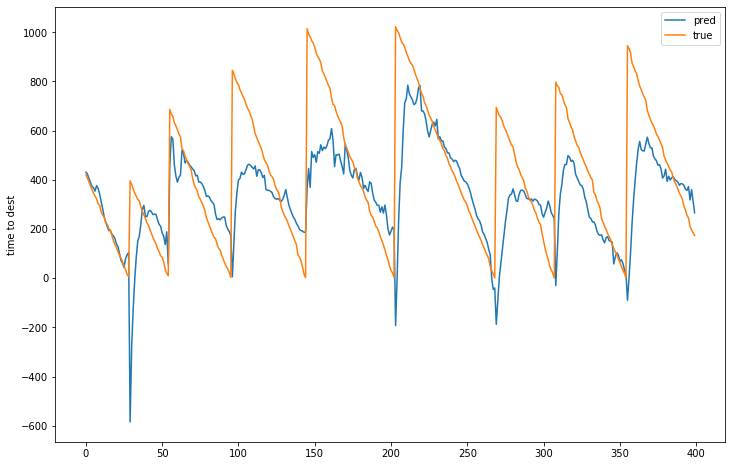

In [322]:
model.fit_generator(generator=generator,
                    epochs=50,
                    steps_per_epoch=200,
                    validation_data=validation_data,
                    callbacks=callbacks)
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)
y_pred = model.predict(np.expand_dims(x_test, axis =0))
# y_pred = model.predict([np.expand_dims(x_test[:,0:2], axis=0), np.expand_dims(x_test[:,2:], axis =0)])
# y_pred = model.predict([np.expand_dims(x_test[:,0:2], axis=0), np.expand_dims(x_test, axis =0)])

y_pred_rescaled = scy.inverse_transform(y_pred[0])
y_test_rescaled = scy.inverse_transform(y_test)

plt.figure(figsize=(12, 8))
plt.ylabel('time to dest')
# plt.plot(y_pred_rescaled, label = 'pred')
# plt.plot(y_test_rescaled, label = 'true')
plt.plot(y_pred_rescaled[1100:1500], label = 'pred')
plt.plot(y_test_rescaled[1100:1500], label = 'true')
plt.legend()

In [258]:
model.save('cnnrnn parallel 2603.h5')

In [999]:
import gc
gc.collect()

4651

In [1153]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [864]:
result = model.evaluate(x=[np.expand_dims(x_test[:,0:2], axis=0).reshape(1,-1,2,1), np.expand_dims(x_test, axis =0)],
                        y=np.expand_dims(y_test, axis=0))

1/1 [==============================] - 1s 1s/sample - loss: 0.0316 - mean_absolute_error: 0.0316


In [83]:
y_pred = model.predict(np.expand_dims(x_test, axis =0))

In [301]:
y_pred = np.clip(y_pred,-1.0,1.0)

In [894]:
y_pred = model.predict([np.expand_dims(x_test[:,0:2], axis=0).reshape(1,2,-1,1), np.expand_dims(x_test, axis =0)])

In [277]:
y_pred = model.predict([np.expand_dims(x_test[:,0:2], axis=0), np.expand_dims(x_test, axis =0)])

In [302]:
y_pred_rescaled = scy.inverse_transform(y_pred[0])
y_test_rescaled = scy.inverse_transform(y_test)

In [305]:
y_pred[0][y_pred[0]> 1]

array([], dtype=float32)

In [ ]:
scy.inverse_transform(y_pred[0][y_pred[0] < -1].reshape(1,-1))

In [585]:
y_pred

array([[[0.03194636],
        [0.03321187],
        [0.02991301],
        ...,
        [0.01069504],
        [0.01074362],
        [0.01027091]]], dtype=float32)

In [583]:
y_pred_rescaled 

array([[685.83997],
       [713.0084 ],
       [642.187  ],
       ...,
       [229.60704],
       [230.64989],
       [220.50168]], dtype=float32)

In [584]:
y_test_rescaled 

array([[1008.61199244],
       [ 994.10646438],
       [ 979.97496105],
       ...,
       [  60.42329355],
       [  16.96941317],
       [   2.81317724]])

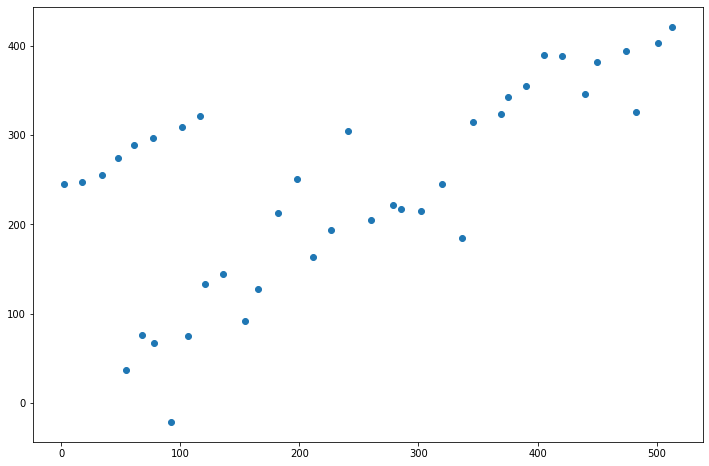

In [656]:
plt.figure(figsize=(12, 8))
plt.scatter(y_test_rescaled[120:160] , y_pred_rescaled[120:160])


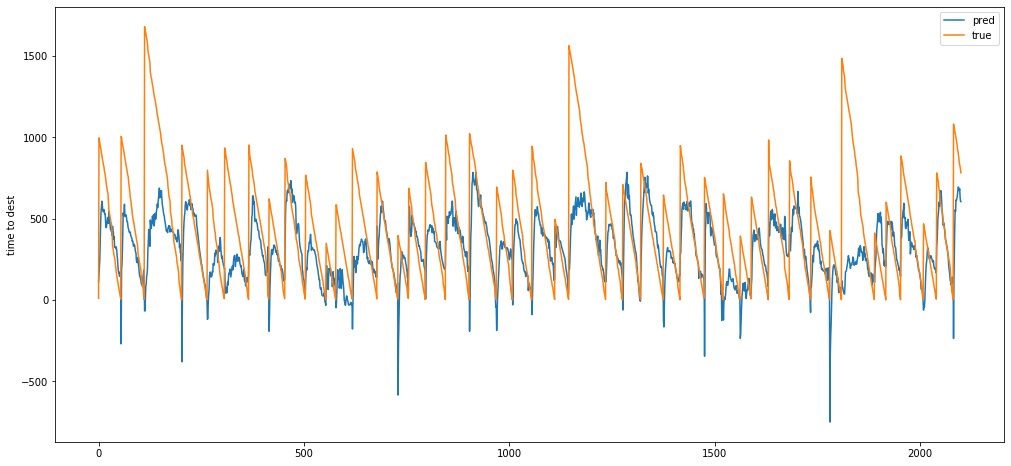

In [323]:
plt.figure(figsize=(17, 8))
plt.ylabel('time to dest')
# plt.plot(y_pred_rescaled, label = 'pred')
# plt.plot(y_test_rescaled, label = 'true')
plt.plot(y_pred_rescaled[400:2500], label = 'pred')
plt.plot(y_test_rescaled[400:2500], label = 'true')
plt.legend()

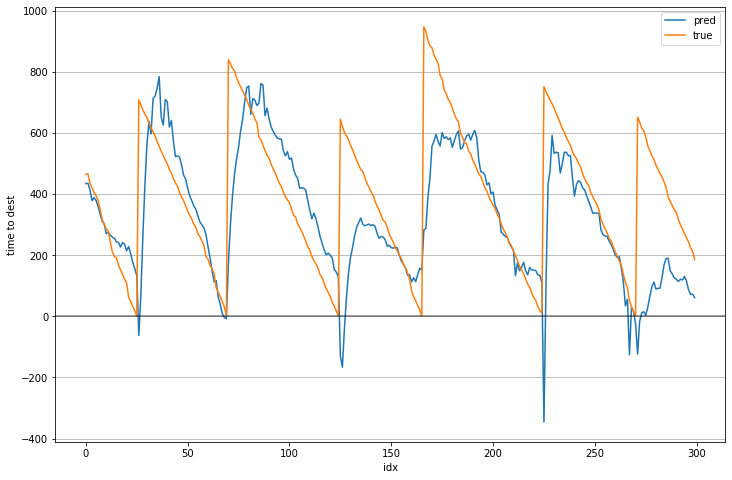

In [324]:
plt.figure(figsize=(12, 8))
plt.ylabel('time to dest')
plt.xlabel('idx')

plt.plot(y_pred_rescaled[1650:1950], label = 'pred')
plt.plot(y_test_rescaled[1650:1950], label = 'true')
plt.grid(axis = 'y')
plt.axhline(0, color='black',alpha = 0.5)
plt.legend()

### x

In [161]:
from sklearn.metrics import mean_absolute_error

In [325]:
mean_absolute_error(y_test_rescaled , y_pred_rescaled )

254.3194663760776

In [1090]:
def tanh(z):
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

In [337]:
def elu(z,alpha):
    return z if z >= 0 else alpha*(np.exp(z) -1)

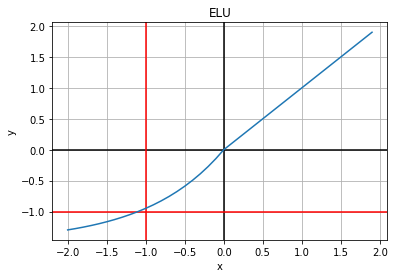

In [372]:
x = np.arange(-2,2,0.1)
y =[]
for i in x:
    y.append(elu(i,1.5))
plt.axvline(0, color='black')
plt.axhline(0, color='black')
plt.axhline(-1, color='red')
plt.axvline(-1, color='red')
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.title('ELU')
plt.show()